In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import torchvision
from torch.utils.data import TensorDataset, random_split, DataLoader
import torch.nn as nn
import time
import wandb
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE
import torch
from datetime import datetime
from collections import OrderedDict
from sklearn.decomposition import PCA
import flwr as fl
from flwr.common import Metrics 
from time import gmtime, strftime
from flwr.server.strategy import FedAvg, FedAdagrad, FedProx
from flwr.common import ndarrays_to_parameters, NDArrays, Scalar, Context

now = datetime.now() # current date and time
date_time = now.strftime("%d-%m-%Y_%H:%M:%S")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using {device}.')

Using cuda.


In [9]:
wandb.init(
    # set the wandb project where this run will be logged
    project="FL",
    name= "without batch normalization_FedAvg_{}".format(date_time),
    # track hyperparameters and run metadata
    config={
    "learning_rate": 0.0001,
    "architecture": "CNN",
    "epochs": 100,
    "loss": nn.BCELoss(),
    "batch_size": 64,
    "decay":1e-5,
    'dropout': 0.1,
    "learning_rate_FL": 0.0001,
    "batch_size_FL": 64,
    "decay_FL":1e-5,
    'num_rounds_FL': 40, 
    'epochs_FL': 100,
    'dropout_FL': 0.001
    
    }
)

configuration  = dict(wandb.config)


def data_loading_AZURE(data_paths, label_paths, batch_size, train_ratio=0.8, val_ratio=0.5):
    trainloader = []
    valloader = []
    testdata_list = []
    testlabels_list = []
    for i in range(len(data_paths)):
        # importing from paths
        data = torch.load(data_paths[i])
        labels = torch.load(label_paths[i])
        data = nn.functional.normalize(data, dim=1)
        # reshaping the dataset so  the channels will be the second dimension.
        data = data.permute(0, 2, 1)
        print(data.size())
        n_samples, n_channels, n_features = data.shape
        X_reshaped = data.reshape(n_samples, -1) 
        # Apply SMOTE
        smote = SMOTE(sampling_strategy='minority')
        data_resampled, labels_resampled = smote.fit_resample(X_reshaped, labels)
        # Reshape X_resampled back to 3D
        data_resampled = data_resampled.reshape(-1, n_channels, n_features)
        print(data_resampled.shape)
        data_resampled = torch.tensor(data_resampled)
        labels_resampled = torch.tensor(labels_resampled)
        dataset = TensorDataset(data_resampled, labels_resampled)
        train_size = int(train_ratio * len(dataset))
        test_size = len(dataset) - train_size
        val_size = int(val_ratio * test_size)
        test_size = test_size - val_size

        train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

        trainloader.append(DataLoader(train_dataset, batch_size=batch_size, shuffle=True))
        valloader.append(DataLoader(val_dataset, batch_size=batch_size, shuffle=True))
        testdata_list.append(test_dataset.dataset.tensors[0][test_dataset.indices])
        testlabels_list.append(test_dataset.dataset.tensors[1][test_dataset.indices])

    testdata = torch.cat(testdata_list, dim=0)
    testlabels = torch.cat(testlabels_list, dim=0)
    print('---------')

    print(testdata.size())

    # Create a DataLoader for the combined test data
    testloader = DataLoader(TensorDataset(testdata, testlabels), batch_size=batch_size, shuffle=False)
    
    return trainloader, valloader, testloader

def data_loading_NASA(data_path, label_path, batch_size, train_ratio=0.8, val_ratio = 0.5):
    data = torch.load(data_path)
    labels = torch.load(label_path)
    data = nn.functional.normalize(data, dim=1)
    # reshaping the dataset so  the channels will be the second dimension.
    data = data.permute(0, 2, 1)
    print(data.size())

    def pca_reduction(data, n_components=4):
        data_reshaped = data.reshape(-1, data.shape[1])

        # Apply PCA
        pca = PCA(n_components=n_components)
        
        data_reduced = pca.fit_transform(data_reshaped)

        # Reshape back to (samples, n_components, time_steps)
        data_reduced = data_reduced.reshape(data.shape[0], n_components, data.shape[2])

        return data_reduced
    print(data.dtype)
    data = pca_reduction(data, n_components=4)
    data =(torch.from_numpy(data)).float()
    n_samples, n_channels, n_features = data.shape
    X_reshaped = data.reshape(n_samples, -1) 
    
    n_samples, n_channels, n_features = data.shape
    X_reshaped = data.reshape(n_samples, -1) 
    
    # Apply SMOTE
    smote = SMOTE(sampling_strategy='minority')
    data_resampled, labels_resampled = smote.fit_resample(X_reshaped, labels)
    print((labels_resampled==1).sum())
    # Reshape X_resampled back to 3D
    data_resampled = data_resampled.reshape(-1, n_channels, n_features)
    print(data_resampled.shape)
    data_resampled = torch.tensor(data_resampled)
    labels_resampled = torch.tensor(labels_resampled)
    dataset = TensorDataset(data_resampled, labels_resampled)
    train_size = int(train_ratio * len(dataset))
    test_size = len(dataset) - train_size
    val_size = int(val_ratio * test_size)
    test_size = test_size - val_size
    train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])
    return DataLoader(train_dataset, batch_size=batch_size, shuffle=True), DataLoader(val_dataset, batch_size=batch_size, shuffle=True), DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


/home/diba/miniconda3/envs/FTL/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


In [10]:
# Define the CNN architecture
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # self.conv0 = nn.Conv1d(in_channels=24, out_channels=4, kernel_size=3)
        # self.bn0 = nn.BatchNorm1d(4)
        self.conv1 = nn.Conv1d(in_channels=4, out_channels=8, kernel_size=5)
        self.bn1 = nn.BatchNorm1d(8)
        self.conv2 = nn.Conv1d(in_channels=8, out_channels=8, kernel_size=5)
        self.bn2 = nn.BatchNorm1d(8)
        self.pool = nn.MaxPool1d(kernel_size=2, padding=0, stride=1)
        # the size of the out channels x number  of nodes 
        self.fc1 = nn.Linear(328, 200)
        self.fc2 = nn.Linear(200, 2)
        self.flatten = nn.Flatten()
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(configuration['dropout'])
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # x = self.relu(self.conv0(x))
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        # x = self.relu(self.bn1(self.conv1(x)))
        # x = self.relu(self.bn2(self.conv2(x)))
        x = self.dropout(x)
        x = self.pool(x)
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x - self.dropout(x)
        x = self.sigmoid(self.fc2(x))
        return x

In [11]:
def correct(logits, y):
    y_hat = logits.argmax(axis=1) # Finds the column with the highest value for each row of `logits`.
    return (y_hat == y).float().sum() # Computes the number of times that `y_hat` and `y` match.

def evaluate_metric(model, data_iter, metric):
    """Compute the average `metric` of the model on a dataset."""
    c = torch.tensor(0.).to(device)
    n = torch.tensor(0.).to(device)
    for X, y in data_iter:
        X, y = X.to(device), y.to(device) # Moves data to `device`
        logits = model(X)
        c += metric(logits, y)
        n += len(y)
    return c*100 / n


In [13]:
def train(model, train_loaders,test_loader, config, epochs, decay, dropout):
    loss = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate'], weight_decay=config['decay'])
    losses = [] # Stores the loss for each training batch
    train_accs = [] # Stores the training accuracy after each epoch
    test_accs = []
    for epoch in range(epochs):
        print(f'\nEpoch {epoch + 1}/{epochs}')
        total, epoch_loss = 0, 0.0
        model.train() # This is necessary because batch normalization behaves differently between training and evaluation
        
        for X, y in train_loaders:
            X, y = X.to(device), y.to(device) # Moves data to `device`
            logits = model(X) # Computes the logits for the batch of images `X`
            l = loss(logits, y) # Computes the loss given the `logits` and the class vector `y`
            optimizer.zero_grad() # Zeroes the gradients stored in the model parameters
            l.backward() # Computes the gradient of the loss `l` with respect to the model parameters

            optimizer.step() # Updates the model parameters based on the gradients stored inside them
            epoch_loss += l
            # train_loss = float(l)
            # losses.append(train_loss) # Stores the loss for this batch
        model.eval() # This is necessary because batch normalization behaves differently between training and evaluation
        train_acc = evaluate_metric(model, train_loaders, correct)
        train_accs.append(train_acc)
        test_acc = evaluate_metric(model, test_loader, correct)
        test_accs.append(test_acc)
    #     print(f'Epoch {epoch+1}: Training accuracy: {train_accs[-1]} Testing accuracy: {test_accs[-1]}.') # Computes and displays training/testing dataset accuracy.
    # print(train_accs)
    plt.plot(list(map(lambda x: x.cpu(),train_accs)), label='Training accuracy')
    plt.plot(list(map(lambda x: x.cpu(),test_accs)), label='Validation accuracy')
    plt.title('accuracies')
    plt.legend()

def test(model, test_loaders,  configuration):
    loss = nn.CrossEntropyLoss()
    test_accs = []
    optimizer = torch.optim.Adam(model.parameters(), lr=configuration['learning_rate'], weight_decay=configuration['decay'])
    test_acc = []
    l = 0.0
    model.eval() # This is necessary because batch normalization behaves differently between training and evaluation
    for X, y in test_loaders:    
        X, y = X.to(device), y.to(device) # Moves data to `device`
        logits = model(X)
        l = loss(logits, y).item()
        test_acc = evaluate_metric(model, test_loaders, correct)
        test_accs.append(test_acc)
        
        # wandb.log({"test_acc": test_acc})
        l /= len(test_loaders)
        end_time = time.perf_counter()
        # print('Testing accuracy: {test_accs[-1]}.')
        return l, test_acc

NASA = data_loading_NASA(data_path='NASA_data_50.pt', label_path= 'NASA_label_50.pt', batch_size= configuration['batch_size'])

torch.Size([848, 24, 50])
torch.float32
685
(1370, 4, 50)


In [14]:
azure_data_paths = ['AZURE_data_1.pt', 'AZURE_data_2.pt','AZURE_data_3.pt','AZURE_data_4.pt']
azure_label_paths = ['AZURE_label_1.pt','AZURE_label_2.pt','AZURE_label_3.pt','AZURE_label_4.pt']
azure_train_loaders, azure_val_loaders, azure_test_loader = data_loading_AZURE(azure_data_paths, azure_label_paths, batch_size=configuration['batch_size_FL'])

torch.Size([1002, 4, 50])
(1670, 4, 50)
torch.Size([936, 4, 50])
(1560, 4, 50)
torch.Size([1242, 4, 50])
(2070, 4, 50)
torch.Size([1014, 4, 50])
(1690, 4, 50)
---------
torch.Size([699, 4, 50])



Epoch 1/100

Epoch 2/100

Epoch 3/100

Epoch 4/100

Epoch 5/100

Epoch 6/100

Epoch 7/100

Epoch 8/100

Epoch 9/100

Epoch 10/100

Epoch 11/100

Epoch 12/100

Epoch 13/100

Epoch 14/100

Epoch 15/100

Epoch 16/100

Epoch 17/100

Epoch 18/100

Epoch 19/100

Epoch 20/100

Epoch 21/100

Epoch 22/100

Epoch 23/100

Epoch 24/100

Epoch 25/100

Epoch 26/100

Epoch 27/100

Epoch 28/100

Epoch 29/100

Epoch 30/100

Epoch 31/100

Epoch 32/100

Epoch 33/100

Epoch 34/100

Epoch 35/100

Epoch 36/100

Epoch 37/100

Epoch 38/100

Epoch 39/100

Epoch 40/100

Epoch 41/100

Epoch 42/100

Epoch 43/100

Epoch 44/100

Epoch 45/100

Epoch 46/100

Epoch 47/100

Epoch 48/100

Epoch 49/100

Epoch 50/100

Epoch 51/100

Epoch 52/100

Epoch 53/100

Epoch 54/100

Epoch 55/100

Epoch 56/100

Epoch 57/100

Epoch 58/100

Epoch 59/100

Epoch 60/100

Epoch 61/100

Epoch 62/100

Epoch 63/100

Epoch 64/100

Epoch 65/100

Epoch 66/100

Epoch 67/100

Epoch 68/100

Epoch 69/100

Epoch 70/100

Epoch 71/100

Epoch 72/100



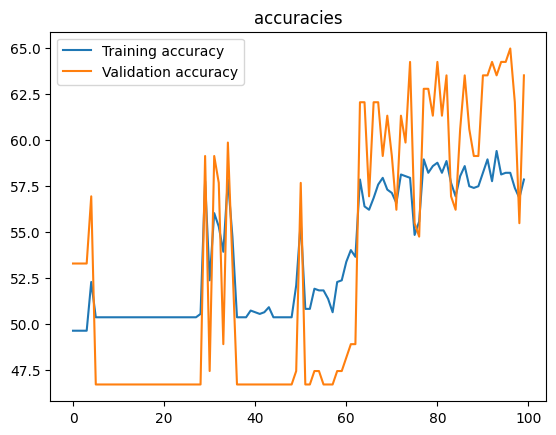

In [15]:
trainloader = NASA[0]
valloader = NASA[1]
testloader = NASA[2]
net = SimpleCNN().to(device)
losses = []
accuracies = []
for epoch in range(1):
    train(net, trainloader, testloader, configuration, configuration['epochs'], configuration['decay'], configuration['dropout'])
    loss, accuracy = test(net, valloader, configuration)
    losses.append(loss)
    accuracies.append(int(accuracy))
    print(f"Epoch {epoch+1}: validation loss {loss}, accuracy {accuracy}")
# plt.plot(accuracies)
loss, accuracy = test(net, testloader, configuration=configuration)

print(f"Final test set performance:\n\tloss {loss}\n\taccuracy {accuracy}")

## transfer learning

For client 1

Epoch 1/100

Epoch 2/100

Epoch 3/100

Epoch 4/100

Epoch 5/100

Epoch 6/100

Epoch 7/100

Epoch 8/100

Epoch 9/100

Epoch 10/100

Epoch 11/100

Epoch 12/100

Epoch 13/100

Epoch 14/100

Epoch 15/100

Epoch 16/100

Epoch 17/100

Epoch 18/100

Epoch 19/100

Epoch 20/100

Epoch 21/100

Epoch 22/100

Epoch 23/100

Epoch 24/100

Epoch 25/100

Epoch 26/100

Epoch 27/100

Epoch 28/100

Epoch 29/100

Epoch 30/100

Epoch 31/100

Epoch 32/100

Epoch 33/100

Epoch 34/100

Epoch 35/100

Epoch 36/100

Epoch 37/100

Epoch 38/100

Epoch 39/100

Epoch 40/100

Epoch 41/100

Epoch 42/100

Epoch 43/100

Epoch 44/100

Epoch 45/100

Epoch 46/100

Epoch 47/100

Epoch 48/100

Epoch 49/100

Epoch 50/100

Epoch 51/100

Epoch 52/100

Epoch 53/100

Epoch 54/100

Epoch 55/100

Epoch 56/100

Epoch 57/100

Epoch 58/100

Epoch 59/100

Epoch 60/100

Epoch 61/100

Epoch 62/100

Epoch 63/100

Epoch 64/100

Epoch 65/100

Epoch 66/100

Epoch 67/100

Epoch 68/100

Epoch 69/100

Epoch 70/100

Epoch 71/100

E

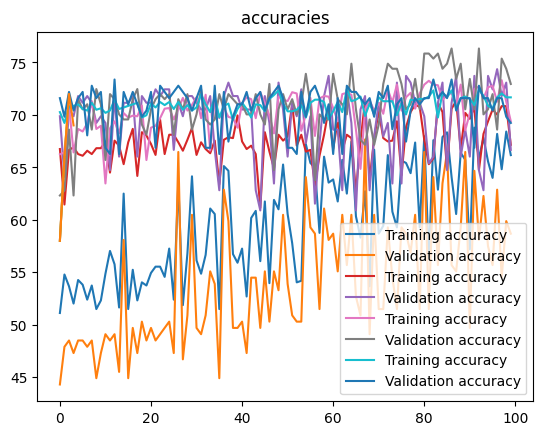

In [18]:
configuration2={
    "learning_rate": 0.0001,
    "architecture": "CNN",
    "epochs": 100,
    "loss": nn.BCELoss(),
    "batch_size": 64,
    "decay":1e-5,
    'dropout': 0.1,
    'number of machines': 20
}
losses = []
accuracies = []
transfer_set = zip(azure_train_loaders, azure_val_loaders)
i = 1
for c_train, c_val in transfer_set:
    print(f"For client {i}")
    for epoch in range(1):
        train(net, c_train, c_val, configuration2, configuration2['epochs'], configuration2['decay'], configuration2['dropout'])
        loss, accuracy = test(net, c_val, configuration)
        losses.append(loss)
        accuracies.append(int(accuracy))
        print(f"Epoch {epoch+1}: validation loss {loss}, accuracy {accuracy}")
    plt.plot(accuracies)
    loss, accuracy = test(net, testloader, configuration=configuration)
    i += 1

    print(f"Final test set performance:\n\tloss {loss}\n\taccuracy {accuracy}")

trainloader = train_loaders[1]
valloader = val_loaders[1]
testloader = test_loaders[1]
net = SimpleCNN().to(device)
losses = []
accuracies = []
for epoch in range(1):
    train(net, trainloader, testloader, configuration, configuration['epochs'])
    loss, accuracy = test(net, valloader, configuration)
    losses.append(loss)
    accuracies.append(int(accuracy))
    print(f"Epoch {epoch+1}: validation loss {loss}, accuracy {accuracy}")
<!-- # plt.plot(accuracies) -->
loss, accuracy = test(net, testloader, configuration=configuration)
print(f"Final test set performance:\n\tloss {loss}\n\taccuracy {accuracy}")

In [19]:
test(net, testloader, configuration)

(0.25546220938364667, tensor(53.2847, device='cuda:0'))

## Federated Learning

importing azure dataset

In [20]:
for name, val in net.state_dict().items():
    
    print(name)

conv1.weight
conv1.bias
bn1.weight
bn1.bias
bn1.running_mean
bn1.running_var
bn1.num_batches_tracked
conv2.weight
conv2.bias
bn2.weight
bn2.bias
bn2.running_mean
bn2.running_var
bn2.num_batches_tracked
fc1.weight
fc1.bias
fc2.weight
fc2.bias


In [21]:
for name, val in net.state_dict().items():
    if ('bn1' not in name and 'bn2' not in name):
        print(name)

'bn1' in 'bn1.bias'

conv1.weight
conv1.bias
conv2.weight
conv2.bias
fc1.weight
fc1.bias
fc2.weight
fc2.bias


True

In [22]:
def get_parameters(model):
    # Return model parameters as a list of NumPy ndarrays, excluding parameters of BN layers when using FedBN
    return [val.cpu().numpy() for name, val in model.state_dict().items() if ('bn1' not in name and 'bn2' not in name)]

def set_parameters(model, parameters):
    # Set model parameters from a list of NumPy ndarrays
    keys = [k for k in model.state_dict().keys() if 'bn' not in k]
    params_dict = zip(keys, parameters)
    state_dict = OrderedDict({k: torch.tensor(v) for k, v in params_dict})
    model.load_state_dict(state_dict, strict=False)


class FlowerClient(fl.client.NumPyClient):
    def __init__(self, net, trainloader, valloader, configuration):
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        return get_parameters(self.net)

    def fit(self, parameters, config):
        set_parameters(self.net, parameters)
        train(self.net, self.trainloader,self.valloader,configuration, configuration['epochs_FL'], configuration['decay_FL'], configuration['dropout'])
        return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader, configuration)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}
    

def client_fn(cid) -> FlowerClient:
    net = SimpleCNN().to(device)
    trainloader = azure_train_loaders[int(cid)]
    valloader = azure_val_loaders[int(cid)]
    return FlowerClient(net, trainloader, valloader, configuration).to_client()


In [23]:

# client will be allocated 1x CPU and 0x GPUs
if device.type == 'cuda':
    # here we are assigning an entire GPU for each client.
    client_resources = {"num_cpus": 1, "num_gpus": 1.0}
    # Refer to our documentation for more details about Flower Simulations
    # and how to setup these `client_resources`.
    
# The `evaluate` function will be called by Flower after every round
fl_acc = []
def evaluate(server_round,parameters,config,):
    net = SimpleCNN().to(device)
    testloader = azure_test_loader
    set_parameters(net, parameters)  # Update model with the latest parameters
    loss, accuracy = test(net, testloader, configuration)
    print(f"Server-side evaluation loss {loss} / accuracy {accuracy}")
    fl_acc.append(accuracy)
    metrics = {'FL loss': loss,
               "FL accuracy": accuracy}
    wandb.log(metrics)
    return loss, {"accuracy": accuracy}

def weighted_average(metrics):
    # Multiply accuracy of each client by number of examples used
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    # Aggregate and return custom metric (weighted average)
    return {"accuracy": sum(accuracies) / sum(examples)}
params = get_parameters(SimpleCNN())
strategy = fl.server.strategy.FedAvg(
    fraction_fit=1,
    fraction_evaluate=0.5,
    min_fit_clients=2,
    min_evaluate_clients=1,
    min_available_clients=1,
    evaluate_fn=evaluate,
    initial_parameters= ndarrays_to_parameters(params),
    evaluate_metrics_aggregation_fn=weighted_average # <-- pass the metric aggregation function
)
# Start simulation
history = fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=4,
    config=fl.server.ServerConfig(num_rounds=configuration['num_rounds_FL']),
    strategy=strategy,
    client_resources=client_resources,
)

Setting `min_available_clients` lower than `min_fit_clients` or
`min_evaluate_clients` can cause the server to fail when there are too few clients
connected to the server. `min_available_clients` must be set to a value larger
than or equal to the values of `min_fit_clients` and `min_evaluate_clients`.

INFO :      Starting Flower simulation, config: num_rounds=40, no round_timeout
2024-08-10 15:53:50,674	INFO worker.py:1621 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'object_store_memory': 51591956889.0, 'accelerator_type:G': 1.0, 'GPU': 2.0, 'CPU': 32.0, 'memory': 110381232743.0, 'node:192.168.1.146': 1.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 1.0}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 2 actors
INFO :      [INIT]
INFO :

Server-side evaluation loss 0.06301333145661787 / accuracy 47.496421813964844
(ClientAppActor pid=1702450) 
(ClientAppActor pid=1702450) Epoch 1/100
(ClientAppActor pid=1702450)  [repeated 303x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/ray-logging.html#log-deduplication for more options.)
(ClientAppActor pid=1702450) Epoch 31/100 [repeated 303x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (1, 0.06263244693929498, {'accuracy': tensor(73.3906, device='cuda:0')}, 9.379323864006437)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.06263244693929498 / accuracy 73.39055633544922
(ClientAppActor pid=1702450)  [repeated 226x across cluster]
(ClientAppActor pid=1702450) Epoch 58/100 [repeated 226x across cluster]
(ClientAppActor pid=1702450)  [repeated 257x across cluster]
(ClientAppActor pid=1702450) Epoch 87/100 [repeated 257x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (2, 0.05895189263603904, {'accuracy': tensor(72.1030, device='cuda:0')}, 17.20231570600299)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.05895189263603904 / accuracy 72.1030044555664
(ClientAppActor pid=1702450)  [repeated 269x across cluster]
(ClientAppActor pid=1702450) Epoch 7/100 [repeated 269x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (3, 0.055580740625208076, {'accuracy': tensor(73.8197, device='cuda:0')}, 24.965487677021883)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.055580740625208076 / accuracy 73.81974029541016
(ClientAppActor pid=1702450)  [repeated 243x across cluster]
(ClientAppActor pid=1702450) Epoch 52/100 [repeated 243x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (4, 0.05427193641662598, {'accuracy': tensor(73.9628, device='cuda:0')}, 31.611590241023805)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.05427193641662598 / accuracy 73.96280670166016
(ClientAppActor pid=1702450)  [repeated 301x across cluster]
(ClientAppActor pid=1702450) Epoch 100/100 [repeated 301x across cluster]
(ClientAppActor pid=1702450)  [repeated 305x across cluster]
(ClientAppActor pid=1702450) Epoch 54/100 [repeated 305x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (5, 0.053614508021961556, {'accuracy': tensor(74.1059, device='cuda:0')}, 38.18102538498351)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.053614508021961556 / accuracy 74.10586547851562
(ClientAppActor pid=1702450)  [repeated 329x across cluster]
(ClientAppActor pid=1702450) Epoch 6/100 [repeated 329x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (6, 0.05330071666023948, {'accuracy': tensor(74.1059, device='cuda:0')}, 45.09825629898114)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.05330071666023948 / accuracy 74.10586547851562
(ClientAppActor pid=1702450)  [repeated 282x across cluster]
(ClientAppActor pid=1702450) Epoch 56/100 [repeated 282x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (7, 0.05314459583976052, {'accuracy': tensor(74.5350, device='cuda:0')}, 52.04204444098286)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


(ClientAppActor pid=1702450)  [repeated 281x across cluster]
(ClientAppActor pid=1702450) Epoch 97/100 [repeated 281x across cluster]
Server-side evaluation loss 0.05314459583976052 / accuracy 74.53504943847656
(ClientAppActor pid=1702450)  [repeated 339x across cluster]
(ClientAppActor pid=1702450) Epoch 69/100 [repeated 339x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (8, 0.052999106320467865, {'accuracy': tensor(75.6795, device='cuda:0')}, 58.012866190983914)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.052999106320467865 / accuracy 75.6795425415039
(ClientAppActor pid=1702450)  [repeated 313x across cluster]
(ClientAppActor pid=1702450) Epoch 32/100 [repeated 313x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (9, 0.05286079103296453, {'accuracy': tensor(75.6795, device='cuda:0')}, 64.324306392984)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.05286079103296453 / accuracy 75.6795425415039
(ClientAppActor pid=1702450)  [repeated 323x across cluster]
(ClientAppActor pid=1702450) Epoch 90/100 [repeated 323x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (10, 0.05266153812408447, {'accuracy': tensor(75.5365, device='cuda:0')}, 70.66228670201963)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 11]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.05266153812408447 / accuracy 75.53648376464844
(ClientAppActor pid=1702450)  [repeated 337x across cluster]
(ClientAppActor pid=1702450) Epoch 53/100 [repeated 337x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (11, 0.05251592397689819, {'accuracy': tensor(75.9657, device='cuda:0')}, 77.43651388498256)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 12]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


(ClientAppActor pid=1702450)  [repeated 288x across cluster]
(ClientAppActor pid=1702450) Epoch 97/100 [repeated 288x across cluster]
Server-side evaluation loss 0.05251592397689819 / accuracy 75.96566772460938
(ClientAppActor pid=1702450)  [repeated 340x across cluster]
(ClientAppActor pid=1702450) Epoch 70/100 [repeated 339x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (12, 0.05237581513144753, {'accuracy': tensor(76.2518, device='cuda:0')}, 83.45971938199364)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 13]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.05237581513144753 / accuracy 76.25178527832031
(ClientAppActor pid=1702450)  [repeated 339x across cluster]
(ClientAppActor pid=1702450) Epoch 33/100 [repeated 339x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (13, 0.05239857326854359, {'accuracy': tensor(75.8226, device='cuda:0')}, 90.15673043800052)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 14]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.05239857326854359 / accuracy 75.82260131835938
(ClientAppActor pid=1702450)  [repeated 203x across cluster]
(ClientAppActor pid=1702450) Epoch 39/100 [repeated 203x across cluster]
(ClientAppActor pid=1702450)  [repeated 173x across cluster]
(ClientAppActor pid=1702450) Epoch 30/100 [repeated 173x across cluster]
(ClientAppActor pid=1702449)  [repeated 143x across cluster]
(ClientAppActor pid=1702449) Epoch 94/100 [repeated 143x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (14, 0.05219731547615745, {'accuracy': tensor(75.9657, device='cuda:0')}, 102.99000489996979)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 15]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.05219731547615745 / accuracy 75.96566772460938
(ClientAppActor pid=1702450)  [repeated 171x across cluster]
(ClientAppActor pid=1702450) Epoch 80/100 [repeated 171x across cluster]
(ClientAppActor pid=1702450)  [repeated 167x across cluster]
(ClientAppActor pid=1702450) Epoch 74/100 [repeated 167x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (15, 0.05204634774814953, {'accuracy': tensor(76.2518, device='cuda:0')}, 115.75635399698513)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 16]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.05204634774814953 / accuracy 76.25178527832031
(ClientAppActor pid=1702450)  [repeated 132x across cluster]
(ClientAppActor pid=1702450) Epoch 29/100 [repeated 132x across cluster]
(ClientAppActor pid=1702450)  [repeated 141x across cluster]
(ClientAppActor pid=1702450) Epoch 97/100 [repeated 141x across cluster]
(ClientAppActor pid=1702450)  [repeated 178x across cluster]
(ClientAppActor pid=1702450) Epoch 89/100 [repeated 178x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (16, 0.05244747617027976, {'accuracy': tensor(75.3934, device='cuda:0')}, 128.53370629798155)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 17]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.05244747617027976 / accuracy 75.39341735839844
(ClientAppActor pid=1702450)  [repeated 151x across cluster]
(ClientAppActor pid=1702450) Epoch 67/100 [repeated 151x across cluster]
(ClientAppActor pid=1702450)  [repeated 155x across cluster]
(ClientAppActor pid=1702450) Epoch 43/100 [repeated 155x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (17, 0.05212725292552601, {'accuracy': tensor(75.6795, device='cuda:0')}, 142.1572934910073)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 18]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.05212725292552601 / accuracy 75.6795425415039
(ClientAppActor pid=1702450)  [repeated 133x across cluster]
(ClientAppActor pid=1702450) Epoch 11/100 [repeated 133x across cluster]
(ClientAppActor pid=1702450)  [repeated 164x across cluster]
(ClientAppActor pid=1702450) Epoch 87/100 [repeated 164x across cluster]
(ClientAppActor pid=1702450)  [repeated 139x across cluster]
(ClientAppActor pid=1702450) Epoch 64/100 [repeated 139x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (18, 0.05216020345687866, {'accuracy': tensor(76.1087, device='cuda:0')}, 155.43388862302527)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 19]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.05216020345687866 / accuracy 76.10872650146484
(ClientAppActor pid=1702450)  [repeated 150x across cluster]
(ClientAppActor pid=1702450) Epoch 34/100 [repeated 150x across cluster]
(ClientAppActor pid=1702450)  [repeated 172x across cluster]
(ClientAppActor pid=1702450) Epoch 16/100 [repeated 172x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (19, 0.051738083362579346, {'accuracy': tensor(76.1087, device='cuda:0')}, 167.14735647302587)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 20]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.051738083362579346 / accuracy 76.10872650146484
(ClientAppActor pid=1702450)  [repeated 191x across cluster]
(ClientAppActor pid=1702450) Epoch 23/100 [repeated 191x across cluster]
(ClientAppActor pid=1702450)  [repeated 195x across cluster]
(ClientAppActor pid=1702450) Epoch 22/100 [repeated 195x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (20, 0.051770231940529564, {'accuracy': tensor(75.9657, device='cuda:0')}, 177.93626714800484)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 21]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.051770231940529564 / accuracy 75.96566772460938
(ClientAppActor pid=1702450)  [repeated 174x across cluster]
(ClientAppActor pid=1702450) Epoch 5/100 [repeated 174x across cluster]
(ClientAppActor pid=1702450)  [repeated 192x across cluster]
(ClientAppActor pid=1702450) Epoch 100/100 [repeated 192x across cluster]
(ClientAppActor pid=1702450)  [repeated 179x across cluster]
(ClientAppActor pid=1702450) Epoch 100/100 [repeated 179x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (21, 0.05159842426126653, {'accuracy': tensor(76.9671, device='cuda:0')}, 189.30356500699418)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 22]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.05159842426126653 / accuracy 76.96709442138672
(ClientAppActor pid=1702450)  [repeated 177x across cluster]
(ClientAppActor pid=1702450) Epoch 75/100 [repeated 177x across cluster]


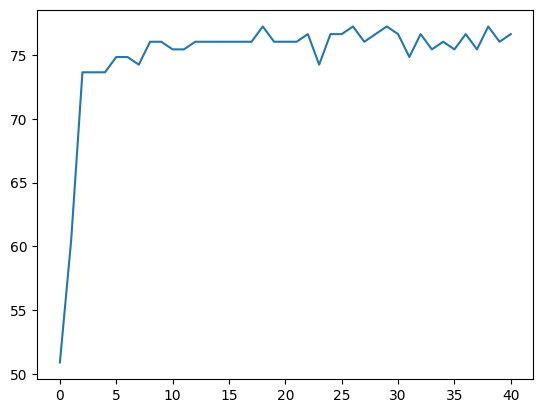

In [ ]:
fl_acc
f = []
for i in fl_acc:
    f.append(float(i))
plt.plot(f)

# client will be allocated 1x CPU and 0x GPUs
if device.type == 'cuda':
    # here we are assigning an entire GPU for each client.
    client_resources = {"num_cpus": 1, "num_gpus": 1.0}
    # Refer to our documentation for more details about Flower Simulations
    # and how to setup these `client_resources`.
def weighted_average(metrics) -> Metrics:
    # Multiply accuracy of each client by number of examples used
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    # Aggregate and return custom metric (weighted average)
    return {"accuracy": sum(accuracies) / sum(examples)}
# Create FedAvg strategy
strategy = fl.server.strategy.FedAvg(
    fraction_fit=1.0,
    fraction_evaluate=0.5,
    min_fit_clients=2,
    min_evaluate_clients=2,
    min_available_clients=2,
    evaluate_metrics_aggregation_fn=weighted_average,  # <-- pass the metric aggregation function
)

# Start simulation
fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=2,
    config=fl.server.ServerConfig(num_rounds=50),
    strategy=strategy,
    # client_resources=client_resources,
)

# client will be allocated 1x CPU and 0x GPUs
if device.type == 'cuda':
    # here we are assigning an entire GPU for each client.
    client_resources = {"num_cpus": 1, "num_gpus": 1.0}
    # Refer to our documentation for more details about Flower Simulations
    # and how to setup these `client_resources`.

fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=2,
    config=fl.server.ServerConfig(num_rounds=5),
    strategy=fl.server.strategy.FedAvg(),
    client_resources=client_resources
)